In [1]:
# Imports

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import json

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sn

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

# BERT model, tokenizer
from tensorflow.python.keras.layers import Flatten

from transformers import TFBertForSequenceClassification, TFAutoModel , AutoTokenizer

In [2]:
# Constants

# Specialis karakterekkel a maximalis kodolt szoveg max hossza

SHUFFLE_RANDOM_STATE = 42
TRAIN_RANDOM_STATE = 42
TEST_RANDOM_STATE = 42

TEXT = 'Sentence'
FILTER = 'Entity'
START_TOKEN = 'START'
TOKEN_LEN = 'LEN'
Y_HEADER = 'LABEL'
LABELS = {
    "NEG": 0,
    "SEM": 1,
    "POZ": 2
}

EKEZET_VALTAS_RAGNAL = {
    'a': 'á',
    'e': 'é'
}

MAX_SEQUENCE_LENGTH = 64

BATCH_SIZE = 16
EPOCHS = 10
# Maximum hány dokumentumot nézzünk. None esetén mindet
TRAIN_PROCESSED_MAX_DOCUMENTS = None
# Maximum hány dokumentumot nézzünk. None esetén mindet
TEST_PROCESSED_MAX_DOCUMENTS = None

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Text processing

fix = 0

def extend_context(text, context, left_index, right_index):
    # TODO: Mi van, ha a neveket sem vesszuk bele?
    global fix
    if type(text) != list:
        text = text.split()
    start_size = 0
    while start_size < 10:
        if left_index > 0:
            left_index -= 1
            context.insert(0, text[left_index])
            if len(text[left_index]) > 1:
                start_size += 1
        if right_index < len(text) -1:
            right_index += 1
            context.append(text[right_index])
            if len(text[right_index]) > 1:
                start_size += 1
        if left_index <= 0 and right_index >= len(text) -1:
            # fix += 1
            break
    return ' '.join(context)

def contextualize(index, debug = False):
    global fix
    text = ' '.join([i for i in re.split(r'( - |(?![%.-])\W)|(-e[\n ])', dataset[TEXT][index]) if i])
    context_start_index = int(dataset[START_TOKEN][index] - 1)
    context_stop_index = int(context_start_index+dataset[TOKEN_LEN][index] - 1)

    context_name_tokens = \
        [t for t in text
                        .split()[context_start_index:context_stop_index+1]]

    context_name = ' '.join(context_name_tokens)
    context_filter = dataset[FILTER][index]

    # Ha ragozunk, akkor a-bol á lesz pl Csaba -> Csabával
    if len(context_name) >= len(context_filter) \
            and context_filter[len(context_filter)-1] in EKEZET_VALTAS_RAGNAL\
            and EKEZET_VALTAS_RAGNAL.get(context_filter[len(context_filter)-1]) == context_name[len(context_filter)-1]:
        context_filter = context_filter[:-1] + context_name[len(context_filter)-1]

    context_list = context_name_tokens
    left_index = context_start_index
    right_index = context_stop_index
    context = extend_context(text, context_list, left_index, right_index)
    return context

    # if len(context_name) < len(filter):
    #     if debug:
    #         print("rovidebb")
    #         print(dataset['ID'][index])
    #         print(dataset[START_TOKEN][index])
    #         print(dataset[FILTER][index])
    #         print(text)
    #         print(text.split())
    #         print(context_name_tokens)
    #         print('-----')
    #     fix += 1
    # elif not context_name.startswith(filter)\
    #         and filter[len(filter)-1] in EKEZET_VALTAS_RAGNAL\
    #         and EKEZET_VALTAS_RAGNAL.get(filter[len(filter)-1]) != context_name[len(filter)-1]:
    #
    #     if debug:
    #         print(EKEZET_VALTAS_RAGNAL.get(filter[len(filter)-1]))
    #         print(context_name)
    #         print(EKEZET_VALTAS_RAGNAL.get(filter[len(filter)-1]) == context_name[len(filter)-1])
    #         print("nem ilyen izes")
    #         print(dataset['ID'][index])
    #         print(dataset[START_TOKEN][index])
    #         print(dataset[FILTER][index])
    #         print(text)
    #         print(text.split())
    #         print(context_name_tokens)
    #         print('-----')
    #     fix += 1

In [5]:
# Load and set up data

dataset = pd.read_csv('db/train.csv', sep=';')
dataset[Y_HEADER] = dataset[Y_HEADER].map(LABELS)
dataset = shuffle(dataset, random_state=SHUFFLE_RANDOM_STATE)
dataset.info()

X_list = []
print(len(dataset.index))
for i  in range(len(dataset.index)):
    X_list.append(contextualize(i))

# print ('need fix: ', fix)

X = np.asarray(X_list)
y = dataset[Y_HEADER].values


X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=TRAIN_RANDOM_STATE)

X_dev, X_test, y_dev, y_test = train_test_split(X_rem, y_rem, train_size=0.5, random_state=TEST_RANDOM_STATE)


y_train_labels = y_train
y_dev_labels = y_dev
y_test_labels = y_test
y_train = to_categorical(y_train, 3)
y_dev = to_categorical(y_dev, 3)
y_test = to_categorical(y_test, 3)

# for i in range(len(X_train) if TRAIN_PROCESSED_MAX_DOCUMENTS is None else TRAIN_PROCESSED_MAX_DOCUMENTS):
#     print(f'X_train[{i}]: ', X_train[i])
#     print(f'y_train[{i}]: ', y_train[i])
# for i in range(len(X_dev) if TEST_PROCESSED_MAX_DOCUMENTS is None else TEST_PROCESSED_MAX_DOCUMENTS):
#     print(f'X_dev[{i}]: ', X_dev[i])
#     print(f'y_dev[{i}]: ', y_dev[i])
# for i in range(len(X_test) if TEST_PROCESSED_MAX_DOCUMENTS is None else TEST_PROCESSED_MAX_DOCUMENTS):
#     print(f'X_test[{i}]: ', X_test[i])
#     print(f'y_test[{i}]: ', y_test[i])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7700 entries, 3856 to 7270
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        7700 non-null   int64 
 1   START     7700 non-null   int64 
 2   LEN       7700 non-null   int64 
 3   Entity    7700 non-null   object
 4   Sentence  7700 non-null   object
 5   URL       7700 non-null   object
 6   LABEL     7700 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 481.2+ KB
7700


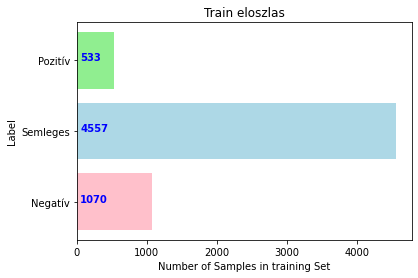

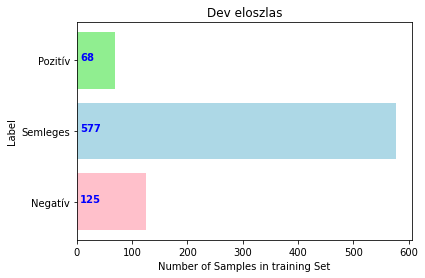

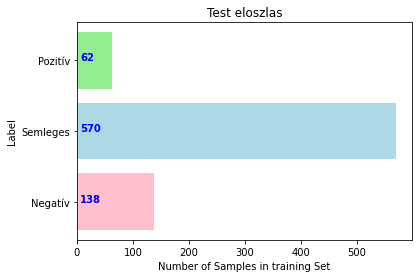

In [6]:
# eloszlas

def plot_label_counts(y, title='y labels'):
    unique, counts = np.unique(y, return_counts=True)
    b = dict(zip(unique, counts))
    plt.barh(range(len(b)), list(b.values()), align='center', color=['pink', 'lightblue', 'lightgreen'])
    y_values = ["Negatív", "Semleges", "Pozitív"]
    y_axis = np.arange(0, 3, 1)
    plt.yticks(y_axis, y_values)
    plt.title(title)
    plt.xlabel('Number of Samples in training Set')
    plt.ylabel('Label')
    ax = plt.gca()
    for i, v in enumerate(b.values()):
        plt.text(ax.get_xlim()[1]/100, i, str(v), color='blue', fontweight='bold')
    plt.show()

plot_label_counts(y_train_labels, 'Train eloszlas')
plot_label_counts(y_dev_labels, 'Dev eloszlas')
plot_label_counts(y_test_labels, 'Test eloszlas')


In [7]:
bert_tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")
bert_model = TFBertForSequenceClassification.from_pretrained("SZTAKI-HLT/hubert-base-cc", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def batch_encode(X):
    return bert_tokenizer.batch_encode_plus(
    X,
    truncation=True,
    max_length=MAX_SEQUENCE_LENGTH,
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    padding='max_length', # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)
X_train = X_train.tolist()
X_dev = X_dev.tolist()
X_test = X_test.tolist()


X_train = batch_encode(X_train[:TRAIN_PROCESSED_MAX_DOCUMENTS])
X_dev = batch_encode(X_dev[:TEST_PROCESSED_MAX_DOCUMENTS])
X_test = batch_encode(X_test[:TEST_PROCESSED_MAX_DOCUMENTS])
y_train = y_train[:TRAIN_PROCESSED_MAX_DOCUMENTS]
y_dev = y_dev[:TEST_PROCESSED_MAX_DOCUMENTS]
y_test = y_test[:TEST_PROCESSED_MAX_DOCUMENTS]

In [15]:
def create_model():
    input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input((64,), dtype=tf.int32, name='attention_mask')
    output = bert_model([input_ids, attention_mask])[0]
    output = tf.keras.layers.Dropout(rate=0.15)(output)
    output = tf.keras.layers.Dense(3, activation='softmax')(output)
    result = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return result

model = create_model()

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
print(bert_model.config)
model.summary()


BertConfig {
  "_name_or_path": "SZTAKI-HLT/hubert-base-cc",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32001
}

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer) 

In [ ]:
checkpoint_path = 'checkpoints/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
# model = tf.keras.models.load_model('models')
# model.load_weights(checkpoint_path)
def fit_model():
    history = model.fit(
        x=X_train.values(),
        y=y_train,
        validation_data=(X_dev.values(), y_dev),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        #callbacks=[EarlyStopping(patience=2)]
        #callbacks=[cp_callback]
    )
    result = model.evaluate(X_test.values(), y_dev)
    predict = model.predict(X_test.values())
    np_predict = np.argmax(predict,axis=1)
    return history, result, np_predict

history, result, predict = fit_model()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def evaluate(predict, history, y):
    y_le = le.fit_transform(y[:TEST_PROCESSED_MAX_DOCUMENTS])
    print('Classification report:')
    print(classification_report(y_le, predict))
    print('Accuracy:')
    print(accuracy_score(y_le, predict))

    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(y_le, predict),
                         index=[i for i in ['positive', 'neutral', 'negative']],
                         columns=[i for i in ['positive', 'neutral', 'negative']])
    plt.figure(figsize=(10,7))
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    plt.show()


print(result)
evaluate(predict, history, y_test_labels)

In [ ]:
# !mkdir -p models
# model.save(os.path.dirname('models/my_model'))